In [0]:
import os
import torch
from torch.nn import functional as F
import itertools
import dataset_loader
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

--2019-11-30 14:10:10--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  21.4MB/s    in 0.7s    

2019-11-30 14:10:11 (21.4 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [0]:
def create_batch(data, index, batch_size):
  if index + batch_size > len(data[0]): batch_size = len(data[0]) - index - 1
  return (torch.cat(
      [
          # we reshape the image tensor so it has dimension (1, 784)
          torch.from_numpy(image).reshape(1, -1)
          for image in data[0][index:index + batch_size]
      ],
      # we want to concatenate on the batch dimension
      dim=0),

      torch.tensor(data[1][index:index + batch_size])
  )

## Part 2: Variational Auto-Encoder¶

To build a new Variational Auto-Encoder, you need two networks:

- An encoder that will take as input an image and compute the parameters of list of Normal distributions
- A decoder that will take a sample from each Normal distribution and will output an image

For simplicity we will assume that:

- each network as a single hidden layer of size 100
- the latent space contains only 2 points

To understand exactly what a VAE is, you can:

- check the slides of Michèle Sebag
- check this tutorial: https://arxiv.org/abs/1606.05908

## 1.2. Encoder

- Compute an hidden representation: z=relu(W1x+b1)
- Compute the means of the normal distributions: mu=W2x+b2
- Compute the log variance of the normal distributions: log_sigma_squared=W3x+b3

In [0]:
class Encoder(torch.nn.Module):
  def __init__(self, input_dim, hdim, normal_dim):
    super().__init__()
    self.z_proj = torch.nn.Linear(input_dim, hdim)
    self.mu = torch.nn.Linear(hdim, normal_dim)
    self.log_sigma_squared = torch.nn.Linear(hdim, normal_dim)

  def forward(self, batch):
    z = self.z_proj(batch)
    z = torch.relu(z)
    mu = self.mu(z)
    log_sigma_squared = self.log_sigma_squared(z)

    e = torch.normal(0, 1., mu.shape)
    z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))

    return z, mu, log_sigma_squared

## 1.2. Decoder

This a simple MLP, nothing new here!

In [0]:
class Decoder(torch.nn.Module):
  def __init__(self, input_dim, hdim, output_dim):
    super().__init__()
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hdim),
        torch.nn.ReLU(),
        torch.nn.Linear(hdim,output_dim)
    )

  def forward(self, batch):
    return self.decoder(batch)

## 1.3. Training loss

To compute the training loss, you must compute two terms:

- a Monte-Carlo estimation of the reconstruction loss
- the KL divergence between the distributions computed by the encoder and the prior

To sample values, you can use the reparameterization trick as follows:

In [0]:
loss_builder = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [0]:
def loss_function(gen_x, x, mu, log_sigma_squared):
    BCE = loss_builder(gen_x, x)

    KLD = -0.5 * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp())

    return BCE + KLD

In [0]:
enc = Encoder(
    784,
    100,
    4
)

In [0]:
dec = Decoder(
    4,
    100,
    784
)

In [0]:
optimizer = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [109]:
batch_size = 128
n_epochs = 50

for epoch in range(n_epochs):
  enc.train()
  dec.train()
  for i in range(0,len(train_data[0]),batch_size):
    batch = create_batch(train_data, i, batch_size)
    x = batch[0]

    z, mu, log_sigma_squared = enc(x)
    gen_x = dec(z)

    loss = loss_function(gen_x, x, mu, log_sigma_squared)

    enc.zero_grad()
    dec.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(itertools.chain(enc.parameters(), dec.parameters()), 5.)  # clip gradient if its norm exceed 5
    optimizer.step()

  print(loss.item())

13031.1044921875
12278.7958984375
11971.7451171875
11807.5908203125
11743.462890625
11585.580078125
11523.0615234375
11490.18359375
11408.53515625
11355.626953125
11316.611328125
11264.1171875
11179.59765625
11141.1533203125
11144.232421875
11109.23828125
11033.4873046875
11046.412109375
11043.9208984375
10946.029296875
10920.7685546875
10903.1201171875
10909.380859375
10898.265625
10878.1826171875
10884.04296875
10818.494140625
10825.0224609375
10817.2919921875
10733.2177734375
10771.828125
10783.884765625
10715.2451171875
10670.734375
10658.3447265625
10681.818359375
10683.1611328125
10667.0087890625
10650.3212890625
10676.119140625
10649.2978515625
10676.1591796875
10633.2998046875
10646.619140625
10591.890625
10565.6201171875
10613.2216796875
10575.109375
10596.2998046875
10575.548828125


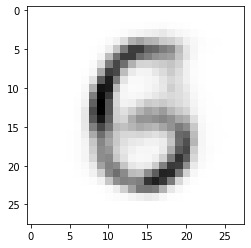

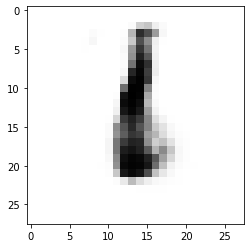

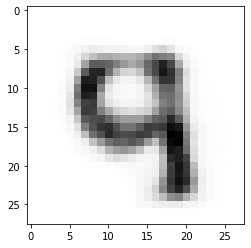

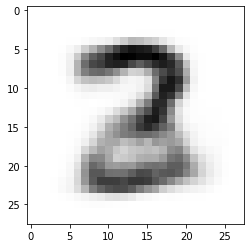

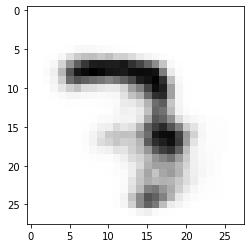

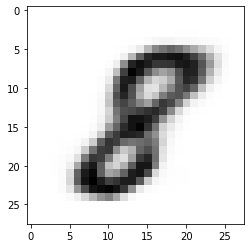

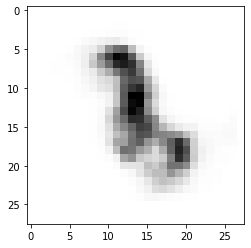

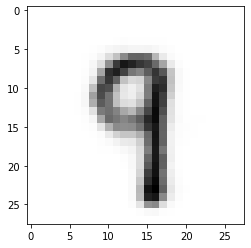

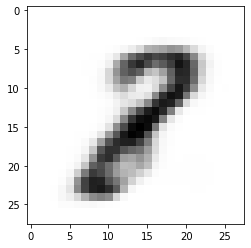

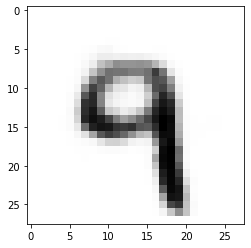

In [111]:
e = torch.normal(0, 1., (10, 4))
images = dec(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()

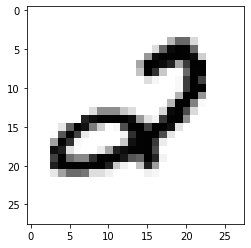

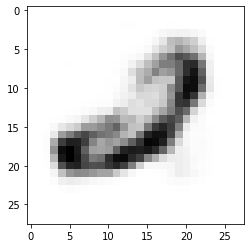

In [133]:
batch = create_batch(dev_data,15,1)
x = batch[0]

plt.imshow(x.reshape(28,28), cmap='Greys')
plt.show()

e, m, s = enc(x)
x_gen = dec(e).sigmoid()

plt.imshow(x_gen.detach().numpy().reshape(28,28), cmap='Greys')
plt.show()

In [0]:
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))



For the reconstruction loss, use the Binary Cross Entropy loss:

In [0]:
loss_builder = torch.nn.BCEWithLogitsLoss(reduction="sum")



The formula of the KL divergence with the prior is as follows:

In [0]:
-0.5 * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp())

## 1.4. Recomended hyper parameters

- Optimizer: Adam
- N. epochs: 50
- Use gradient clipping!
- Large batch size, e.g. 128

In [0]:
# use itertools.chain to join parameters of the two networks
optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
torch.nn.utils.clip_grad_value_(itertools.chain(encoder.parameters(), decoder.parameters()), 5.)

## 1.5. Generate new images

Note: they will be blurry, but that's ok!

In [0]:
e = torch.normal(0, 1., (10, 2))
images = decoder(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()